---

<h1><center>RUL Prediction of Nasa Turbofan Engine - Group 45 <br><br> FD001 Dataset </center></h1>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng_seed = 2434 # Define seed for repeatability

# 1.1 Load Datasets and Append Target (RUL Series) to Datasets

In [2]:
# Column names from "Damage Propogation Modeling"
column_names = [
    'unit_number', 'time', 
    'altitude', 'machnum','tra',
    'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30',
    'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc',
    'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]

# Load .txt files
raw_train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
raw_test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
true_RUL = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# 1.2 Compute and Append Target (RUL Series) to Datasets
In general, $RUL=t_{fail}-t$. However, since each unit in the datasets begins in a healthy state with constant sensor readings, a purely linear model resulted in poor model prediction. Ideally, changepoint detection would be implemented to identify the constant and linear regime of RUL but this is out of scope. instead, the same piecewise RUL function is used where:
$$
RUL = \begin{cases} 
      RUL_{max} & t_{fail}-t > RUL_{max} \\
      t_{fail}-t & t_{fail}-t \leq RUL_{max}
   \end{cases} 
$$
A coarse value for `RUL_MAX` was found by inspecting the graphs of various sensors in the training data. `RUL_MAX=105` was found by manually search (changing RUL_MAX until an approximate stationary point in the training score was found).

In [3]:
# Define the variable for the RUL ceiling
RUL_MAX = 105

# Calculate RUL series (target) for each unit ID in training data using failure time 'T_fail'
RUL_series = np.array([])
unique_units = raw_train['unit_number'].unique()
for unit_ID in unique_units:
    unit_data = raw_train[raw_train['unit_number'] == unit_ID].copy()
    T_fail = unit_data['time'].max() # Since training set is run-to-failure
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implementing Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_train['RUL'] = RUL_series 

# Calculate RUL series for each Unit ID in test data using 'true_RUL'
RUL_series = np.array([])
for index, unit_ID in enumerate(unique_units):
    unit_data = raw_test[raw_test['unit_number'] == unit_ID].copy()
    
    T_last = unit_data['time'].max()
    RUL_last = true_RUL['RUL'][index]
    T_fail = T_last + RUL_last
    
    RUL_linear = T_fail - unit_data['time']
    
    # Implementing Piecewise RUL
    RUL_series = np.concatenate((RUL_series, np.minimum(RUL_linear, RUL_MAX)),axis=0)
    
raw_test['RUL'] = RUL_series

# 1.3 Prune Test Data
We are only concerned with predicting RUL for the last cycle of each unit in test data since `RUL_FD001.txt` only gives the true RUL for the last cycle. Thus, all rows before the last cycle are removed.

In [4]:
raw_test = raw_test.groupby('unit_number').last().reset_index()

# 1.4 Inspect and Clean Datasets
Inspect and remove columns from `raw_train` and `raw_test` if they contain Null or NaN values. No such columns were found

In [5]:
# Make copy of data sets
clean_train = raw_train.copy()
clean_test = raw_test.copy()

# Identify if columns have null values
is_null_arr = pd.isnull(clean_train)
col_has_null = np.any(is_null_arr ,axis=0)
drop_null_cols = clean_train.columns[col_has_null]
clean_train.drop(drop_null_cols, axis=1)
clean_test.drop(drop_null_cols, axis=1)
drop_null_cols

Index([], dtype='object')

In [6]:
# Identify if columns have NaN values
is_nan_arr = pd.isna(clean_train)
col_has_nan = np.any(is_nan_arr, axis=0)
drop_nan_cols = clean_train.columns[col_has_nan]
clean_train.drop(drop_nan_cols, axis=1)
clean_test.drop(drop_nan_cols, axis=1)
drop_nan_cols

Index([], dtype='object')

# 1.5 Feature Selection and Defining Input and Output Dataframes
Features are removed based on two rudimentary criteria:
1. Features that are constant across all units are removed because they hold no statistical power
2. If 2 features are highly correlated, they are redundant and one may be removed
+ **Additionally:**
1. The `'unit_number'` feature is merely to partition the time series of different instances of simulated turbofan engines **within the same dataset** which have randomly generated starting healths (efficiency and flow parameters) and degradation trajectorys (parameters of an exponential degradation model) sampled from the same distributions. `'unit_number'=1` in `train_FD001.txt` and `test_FD001.txt` are **different instances** and should not be conflated. Thus, `unit_number` is removed from the datasets to prevent the models from biasing the predictions due to arbitrarily matching unit IDs.
2. The columns representing the operational settings are **known** to be held constant for `FD001` so they are removed

In [7]:
drop_cols = ['unit_number', 'altitude', 'machnum', 'tra'] # Remove settings columns

# Check which sensors have constant values across all units
unique_count_series = clean_train.nunique()
unique_count_series[unique_count_series == 1]

tra          1
T2           1
P2           1
epr          1
farB         1
Nf_dmd       1
PCNfR_dmd    1
dtype: int64

In [8]:
drop_cols += ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd'] # Remove useless sensors

# Identify feature pairs that have a abs(corr) higher than a threshhold
covariance_mat = clean_train.corr()
thresh = 0.95
highly_correlated_pairs = covariance_mat.stack().rename('Correlation')
highly_correlated_pairs = highly_correlated_pairs[abs(highly_correlated_pairs) >= thresh]
highly_correlated_pairs[highly_correlated_pairs != 1] # Remove pairs from diagonal entries

Nc   NRc    0.963157
NRc  Nc     0.963157
Name: Correlation, dtype: float64

In [9]:
drop_cols += ['NRc']

# Form feature and target matrices
Xtrain = clean_train.drop(drop_cols + ['RUL'], axis=1)
ytrain = clean_train['RUL']
Xtest = clean_test.drop(drop_cols + ['RUL'], axis=1)
ytest = clean_test['RUL']

# 2.1 Create Positive MSE Scoring Function for GridSearchCV()
`GridSearchCV()` by default tries to maximize the evaluation for the scorer. In order to minimize the scorer, we explicitly define the positive mean squared error (MSE) and set `greater_is_better=False`. This allows `hypersolve()` to output the positive MSE by default, as well as make the same scorer available to the rest of the program in evaluating model performance on the test data.

In [10]:
from sklearn.metrics import make_scorer

# define scoring function
def PMSE(y,yhat):
    d = yhat-y
    n = len(y)
    score = 1/n * np.sum((d)**2)
    return score

# Make scoring function accesible to GridSearchCV()
my_scorer = make_scorer(PMSE,greater_is_better=False)

# 2.2 Hyper Parameter Tuning With Gridsearch
Will use `hypersolve()` from lab06 to tune hyperparameters. `plot_grid_results()` from `lab6_utils.py` was modified to plot negative MSE instead of accuracy. 
+ **NOTE:** `scoring='neg_mean_squared_error'` and `refit='neg_mean_squared_error'` arguments passed to `GridSearchCV()` for regression models,

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lab6_utils import unpack_gridsearch, plot_grid_result

# Copied from Lab 06
def hypersolve(model,param_grid):
    # 1. Create the pipeline model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # 2. Construct the `GridSearchCV` object as was done in part 5.2
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=my_scorer, # pass custom scoring function
        cv=3,
        refit=True
    )
    
    # 3. Run the grid search
    gs = gs.fit(Xtrain,ytrain)
    
    # 4. Run `unpack_gridsearch` to obtain the results dictionary.
    result = unpack_gridsearch(gs)

    # 5. Plot the result with `plot_grid_result`
    plot_grid_result(result)

    # 6. return result
    return result

# 3.1 Train Random Forest Regressor

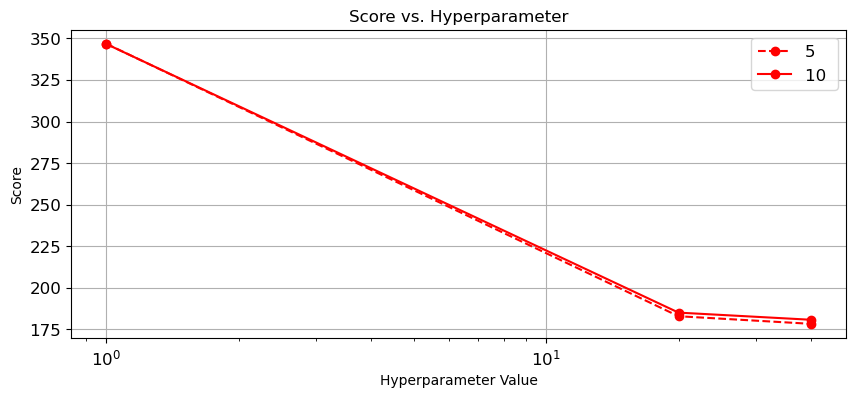

In [12]:
from sklearn.ensemble import RandomForestRegressor

# Define grid of viable hyper parameters
param_grid_rf = {
    'model__max_features' : [5, 10],#len(Xtrain.columns)],
    'model__n_estimators' : [1, 20, 40]
}

# Define an fit RF model
model = RandomForestRegressor(random_state=rng_seed)
result_rf = hypersolve(model, param_grid_rf)

# 3.2 Store Best Random Forest Model and Training Score

In [13]:
best_rf_model = result_rf['best_estimator']
rf_train_score = result_rf['best_score']
print("Random Forest training score (PMSE):", rf_train_score)

Random Forest training score (PMSE): 178.37045329237557


# 3.3 Predict Test RUL With Best Random Forest Regressor and Store Test Score
**NOTE:** test score will be higher than training score because `clean_test` was pruned to only include the last time cycle of each unit

In [14]:
yhat_rf = best_rf_model.predict(Xtest)
rf_test_score = PMSE(true_RUL['RUL'],yhat_rf)
print("Random Forest test score (PMSE):", rf_test_score)

Random Forest test score (PMSE): 404.82281875000007


# 3.4 Plot Random Forest Prediction
Plot predicted and true RUL for all the last cycle of all units in test dataset

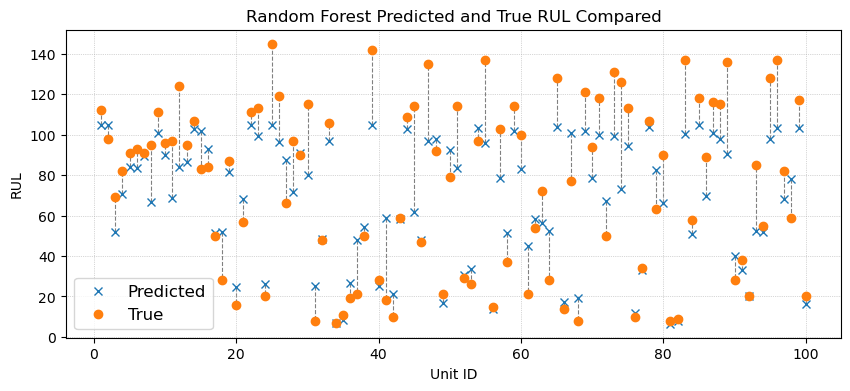

In [15]:
x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat_rf).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )

plt.title('Random Forest Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()

# 4.1 Linear Regression (Baseline Model)
As a simple linear baseline, we first standardize all input features using StandardScaler and then fit an ordinary least squares Linear Regression model. 

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Scale training and test data
scaler_lin = StandardScaler()
X_train_lin = scaler_lin.fit_transform(Xtrain)
X_test_lin  = scaler_lin.transform(Xtest)

# Fit baseline Linear Regression model
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train_lin, ytrain.values)

LinearRegression()

# 4.2 Store Best Linear Regression Model and Training Score


In [17]:
yhat_train_lin = lin_model.predict(X_train_lin)                    # Compute training predictions
lin_train_score = PMSE(ytrain.values, yhat_train_lin)  # Compute training score

print("Linear Regression training score (PMSE):", lin_train_score)

Linear Regression training score (PMSE): 268.03703019865947


# 4.3 Predict Test RUL with Best Linear Regression and Store Test Score

In [18]:
yhat_test_lin = lin_model.predict(X_test_lin)                     # Predict test set RUL
lin_test_score = PMSE(true_RUL['RUL'].values, yhat_test_lin)    # Compute test score

print("Linear Regression test score (PMSE):", lin_test_score)

Linear Regression test score (PMSE): 588.4495841927973


# 4.4 Plot Linear Regression Prediction


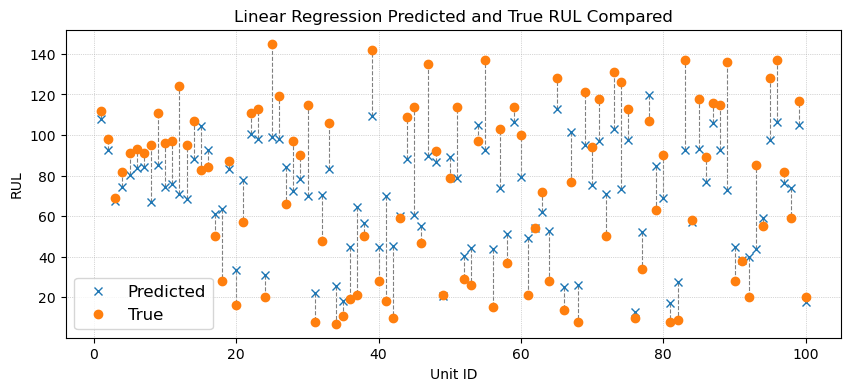

In [19]:
x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat_test_lin).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )

plt.title('Linear Regression Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()


# 5.1 Train Multi-Layer Perception (MLP)


In [20]:
# %pip install --upgrade pip
# %pip install "numpy<1.24"
# %pip install --upgrade tensorflow==2.19.0

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler

np.random.seed(rng_seed)      # numpy random seed
tf.random.set_seed(rng_seed)  # tensorflow global seed
# scaling
scaler_mlp = StandardScaler()
X_train_mlp = scaler_mlp.fit_transform(Xtrain)
X_test_mlp  = scaler_mlp.transform(Xtest)

y_train_mlp = ytrain.values
y_true_mlp  = true_RUL['RUL'].values

def build_mlp(h1, h2, h3, lr):
    D = X_train_mlp.shape[1]
    ki = GlorotUniform(seed=rng_seed)

    model = Sequential([
        Dense(h1, activation='relu', kernel_initializer=ki, input_shape=(D,)),
        Dense(h2, activation='relu', kernel_initializer=ki),
        Dense(h3, activation='relu', kernel_initializer=ki),
        Dense(1, activation='linear', kernel_initializer=ki),
    ])

    model.compile(
        optimizer=RMSprop(learning_rate=lr),
        loss='mse'
    )
    return model

# Hyperparameter grid

grid_h1 = [32, 64]
grid_h2 = [16, 32]
grid_h3 = [8, 16]
grid_lr = [1e-3, 5e-4]

best_score = float("inf")
best_params = None
best_mlp_model = None

for h1 in grid_h1:
    for h2 in grid_h2:
        for h3 in grid_h3:
            for lr in grid_lr:

                model = build_mlp(h1, h2, h3, lr)

                model.fit(
                    X_train_mlp,
                    y_train_mlp,
                    epochs=20,
                    shuffle=False,     
                    batch_size=256,
                    verbose=0,
                    validation_split=0.2
                )

                preds = model.predict(X_test_mlp).reshape(-1)
                score = PMSE(y_true_mlp, preds)

                print(f"h1={h1}, h2={h2}, h3={h3}, lr={lr} → score={score}")

                if score < best_score:
                    best_score = score
                    best_params = (h1, h2, h3, lr)
                    best_mlp_model = model

print("Best score:", best_score)
print("Best params:", best_params)


2025-12-05 21:08:35.586131: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 21:08:35.589111: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-05 21:08:35.595544: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-05 21:08:35.614833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764997715.649866   14478 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764997715.66

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
h1=32, h2=16, h3=8, lr=0.001 → score=503.79423535399854
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
h1=32, h2=16, h3=8, lr=0.0005 → score=938.3654212156497
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f95fd7839c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
h1=32, h2=16, 

# 5.2 Evaluate Training Performance of Best MLP Model


In [22]:
# predict on training set
yhat_mlp_train = best_mlp_model.predict(X_train_mlp).reshape(-1)
# compute training score
mlp_train_score = PMSE(y_train_mlp, yhat_mlp_train)

print("MLP Training Score (PMSE):", mlp_train_score)

645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step
MLP Training Score (PMSE): 196.40721879812403


# 5.3 Evaluate Test RUL with Best MLP Model and Store Final Test Score

In [23]:
yhat_mlp_test = best_mlp_model.predict(X_test_mlp).reshape(-1)
mlp_test_score = PMSE(y_true_mlp, yhat_mlp_test)

print("MLP Test Score (PMSE):", mlp_test_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
MLP Test Score (PMSE): 476.81189000675994


# 5.4 Plot MLP Prediction



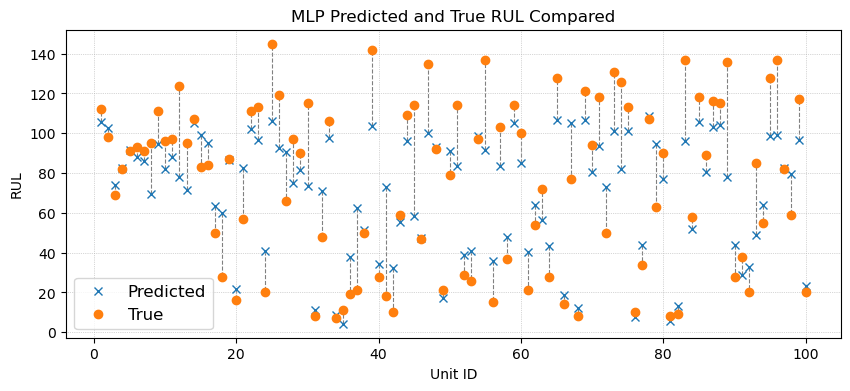

In [24]:
x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat_mlp_test).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )

plt.title('MLP Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()


# 6.1 Build and Train Gradient Boosting Trees for RUL Prediction

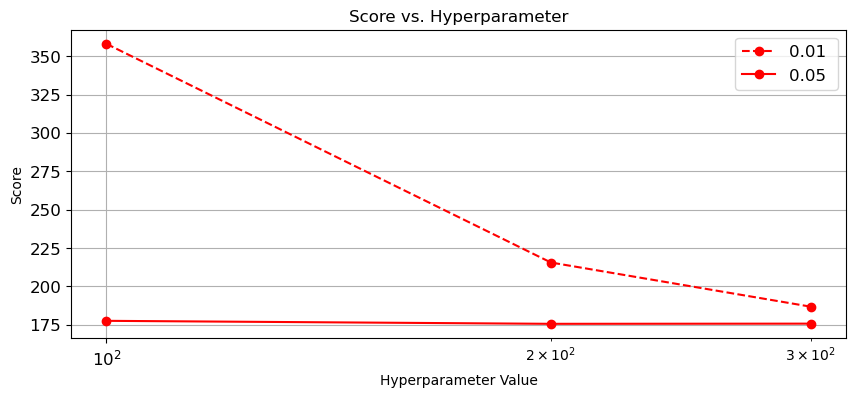

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor(random_state=rng_seed)

param_grid_gb = {
    'model__learning_rate': [0.01, 0.05],    
    'model__n_estimators': [100, 200, 300]  
}

result_gb = hypersolve(model_gb, param_grid_gb)

# 6.2 Store Best Gradient Boosting Trees Model and Training Score

In [26]:
best_gb_model = result_gb['best_estimator']
gb_train_score = result_gb['best_score']
print("Gradient Boosting Trees training score (PMSE):", gb_train_score)

Gradient Boosting Trees training score (PMSE): 175.677177575257


# 6.3 Predict Best Gradient Boosting Trees Model Score 

In [27]:
yhat_gb = best_gb_model.predict(Xtest)
gb_test_score = PMSE(true_RUL['RUL'],yhat_gb)
print("Gradient Boosting Trees test score (PMSE):", gb_test_score)

Gradient Boosting Trees test score (PMSE): 385.9513766470105


# 6.4 Plot Best Gradient Boosting Trees Predictions and True RUL Comparison

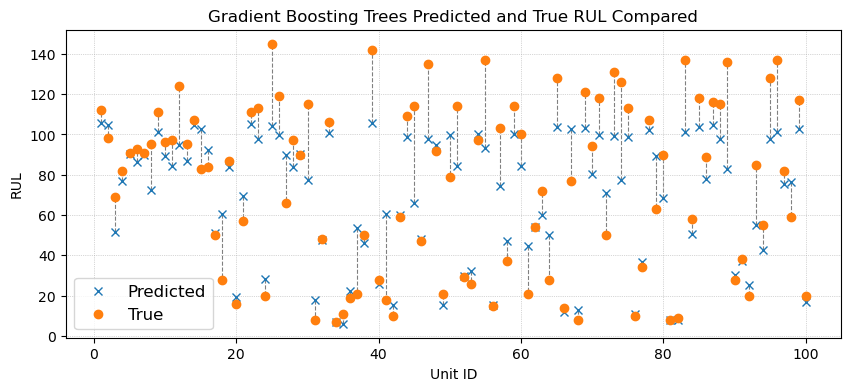

In [28]:
x = np.asarray(clean_test['unit_number'].to_numpy())
y_pred = np.asarray(yhat_gb).ravel()
y_true = np.asarray(true_RUL).ravel()

assert len(x) == len(y_pred) == len(y_true)

plt.figure(figsize=(10,4))

#Plot predicted and true
plt.plot(x, y_pred, label='Predicted', marker='x', linestyle='None')
plt.plot(x, y_true, label='True', marker='o', linestyle='None')

#Connect each predicted point to the corresponding true value
for i in range(len(x)):
    plt.plot(
        [x[i], x[i]],
        [y_pred[i], y_true[i]],
        color='gray',
        linestyle='--',
        linewidth=0.8,
        zorder=0
    )

plt.title('Gradient Boosting Trees Predicted and True RUL Compared')
plt.xlabel('Unit ID')
plt.ylabel('RUL')
plt.legend(fontsize=12)
plt.grid(axis='both', linestyle=':', linewidth=0.5)
plt.show()